In [1]:
# 📦 Install dependencies
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python matplotlib scikit-image scikit-learn

# 🔽 Download the SAM model checkpoint
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O sam_vit_h.pth



  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-g96f_sbp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-g96f_sbp
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=2d29664927f2b40017f590053139e57b48171ebf8193fe20e17a71f3a07abea5
  Stored in directory: /tmp/pip-ephem-wheel-cache-6c5cdgl2/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-05-07 12:09:44--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.170.229.81, 3.170.229.102, 3.170.229.64, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.170.22

Saving IMG_0564.jpg to IMG_0564.jpg


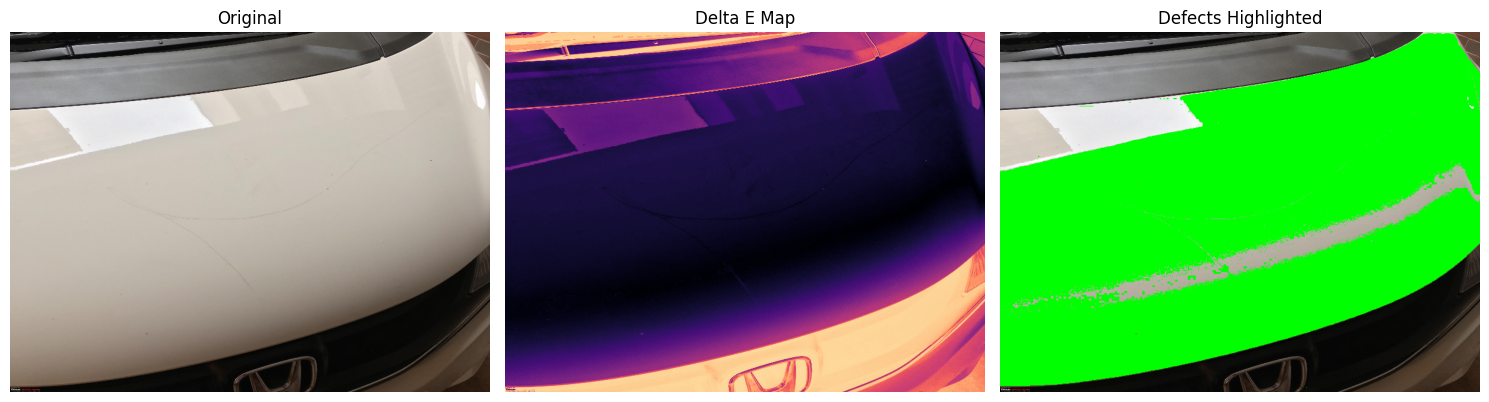

In [ ]:
# 📂 Upload your car image
from google.colab import files
uploaded = files.upload()

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from PIL import Image
from skimage import color
from sklearn.cluster import KMeans

# 🖼️ Load the image
file_path = next(iter(uploaded))
image_bgr = cv2.imread(file_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_rgb = cv2.resize(image_rgb, (800, 600))

# 🧠 Load SAM model
sam_checkpoint = "sam_vit_h.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device='cuda' if torch.cuda.is_available() else 'cpu')
mask_generator = SamAutomaticMaskGenerator(sam)

# 🎯 Generate masks
masks = mask_generator.generate(image_rgb)

# 🔍 Pick largest mask (assuming car is main object)
largest_mask = max(masks, key=lambda x: np.sum(x['segmentation']))
mask = largest_mask['segmentation']

# 🎨 Extract dominant color inside the mask using KMeans
masked_pixels = image_rgb[mask]
kmeans = KMeans(n_clusters=1, n_init=10)
kmeans.fit(masked_pixels)
dominant_rgb = kmeans.cluster_centers_[0].astype(np.uint8)
ref_rgb = dominant_rgb.reshape(1, 1, 3)
ref_lab = color.rgb2lab(ref_rgb)

# 📏 Convert image to LAB and compute Delta E
lab_img = color.rgb2lab(image_rgb)
delta_e = color.deltaE_cie76(lab_img, ref_lab)
defect_mask = (delta_e > 2) & mask  # only in car region

# 📌 Highlight defects
highlighted_img = image_rgb.copy()
highlighted_img[defect_mask] = [0, 255, 0]  # green for defects

# 📊 Show results
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Delta E Map")
plt.imshow(delta_e, cmap='magma')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Defects Highlighted")
plt.imshow(highlighted_img)
plt.axis('off')

plt.tight_layout()
plt.show()
